## Trabalho Prático 

Trabalho realizado por: 
                        
                        Jorge André Vieira Freitas A87944
                        David Silvestre Ölund Matos A87997

## 1. Algoritmo

In [20]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton

import matplotlib.pyplot as plt
%matplotlib inline

Neste trabalho prático foi-nos pedido para implementar um algoritmo que descubra s, sendo s = N mod 8.

In [21]:
s = 3 % 8
print(s)

3


In [22]:
sb = bin(s)[2:] 

print(sb)

11


O nosso objetivo é encontrar o s = 3, 011 em binário. Para tal, vamos utilizar o Algoritmo de Grover, um algoritmo rápido para resolver problemas de procura em estruturas de dados.

In [23]:
x = 3 
print('number of qubits: ', x)

number of qubits:  3


In [24]:
backend = Aer.get_backend("qasm_simulator")

In [25]:
qr_x = QuantumRegister(x, 'x')

A aplicação do algoritmo de Grover pode ser sintetizado em 3 fases: a inicialização, seguida de uma repetição das duas seguintes fases, o Oráculo e a Amplificação, aproximadamente $\sqrt{N}$ vezes. Para obtermos o resultado pretendido s(011), será necessário criar um oracle e um diffuser. O objetivo do oracle é identificar o s(011) e inverter as amplitudes para o destacar e em seguida o diffuser re-inverte e amplifica essa amplitude.

In [26]:
def select_w(circuit, qr_x):
    circuit.x(qr_x[2])

A "phase_oracle" irá chamar a "select_w" que irá adicionar um gate x no segundo quibit(quibit que queremos a 0) para contrariar o comportamento do gate Z, e em seguida um gate Z que irá inverter a amplitude do s(011), porém como o gate Z não existe teremos de executar um gate H CCX H.

In [27]:
def phase_oracle(circuit, qr_x):
    select_w(circuit,qr_x)
    
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0],qr_x[1],qr_x[2])
    circuit.h(qr_x[2])
    
    select_w(circuit,qr_x)

Após a inversão da amplitude, temos como objetivo aumentar essa amplitude, pois ainda não alteramos valores nenhuns de modo a aumentar a probabilidade de obtermos s(011). Para tal usamos a função "diffuser" que irá aplicar um gate X a todos os quibits para inverter o efeito da porta H CCX H(CCZ).

In [28]:
def diffuser(circuit, qr_x):
    circuit.h(qr_x)
    circuit.x(qr_x)
    circuit.h(qr_x[2])
    circuit.ccx(qr_x[0],qr_x[1],qr_x[2])
    circuit.h(qr_x[2]) #CCCCZ -> CCZ
    circuit.x(qr_x)
    circuit.h(qr_x)

Vamos agora fazer as medições dos qubit para medir o resultado final.

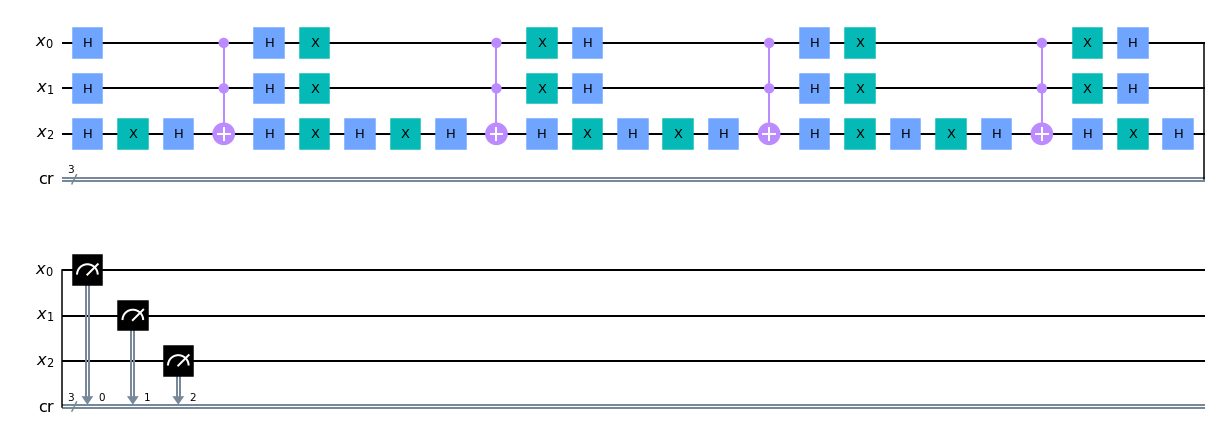

In [29]:
cr=ClassicalRegister(x,'cr')
qc_Grover = QuantumCircuit(qr_x,cr)

# init
qc_Grover.h(qr_x)

for t in range(2):
    # phase oracle  
    phase_oracle(qc_Grover,qr_x)
    # diffuser
    diffuser(qc_Grover,qr_x)
    
qc_Grover.measure(qr_x,cr)

qc_Grover.draw(output='mpl')

In [30]:
backend_state = Aer.get_backend('statevector_simulator') 
result = execute(qc_Grover, backend_state).result()
psi1  = result.get_statevector(qc_Grover)

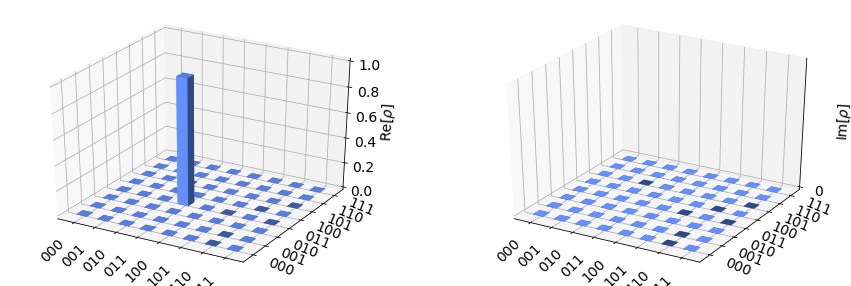

In [31]:
plot_state_city(psi1)

In [32]:
import math as m

times= round(m.sqrt(2**x))
print(times)

3


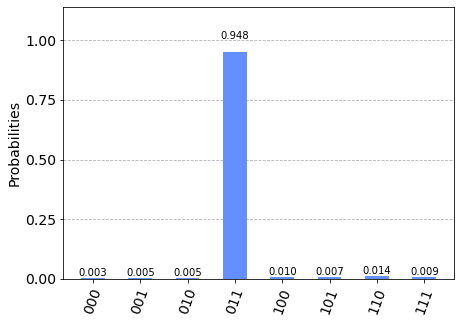

In [33]:
counts = execute(qc_Grover, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [34]:
qc_Grover.depth()

26

## 2. Simulação com ruído

Vamos agora simular o mesmo algoritmo acima apresentado, porém será com ruído que consiste em reter informação de computadores quanticos e iremos escolher qual backend iremos usar.

In [35]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [36]:
import qiskit.tools.jupyter

%qiskit_backend_overview
from qiskit.tools.monitor import backend_overview, backend_monitor

Para correr o algoritmo deste trabalho prático num computador quántico será necessário escolher o mais disponível no momento, mas que garanta também uma taxa de erros menor. 

Por estes motivos escolhemos o ibmq_santiago, que apresenta um Avg. CX Err. e Avg. Meas. Err. menor que todos os outros, está relativamente livre para executar o "job" e contém 5 quibits o que é mais que necessário.

In [37]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

backend_device = my_provider_ibmq.get_backend('ibmq_santiago')

backend_device

<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>

In [38]:
coupling_map = backend_device.configuration().coupling_map

In [39]:
from qiskit.providers.aer.noise import NoiseModel

In [40]:
noise_model = NoiseModel.from_backend(backend_device)

In [41]:
basis_gates = noise_model.basis_gates

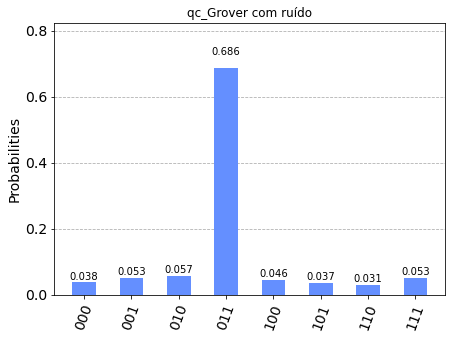

In [42]:
result_noise = execute(qc_Grover, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(qc_Grover)
plot_histogram(counts_noise, title="qc_Grover com ruído")

In [43]:
print(counts_noise)

{'111': 54, '110': 32, '011': 702, '010': 58, '001': 54, '100': 47, '101': 38, '000': 39}


In [44]:
def resume(counts_raw):
    s0=s1=0
    k=counts_raw.keys()
    lk=list(k)
    for c in lk:
        if c[0]=='0':
            s0 = s0 + counts_raw.get(c)
        else:
            s1 = s1 + counts_raw.get(c)
    return({'0':s0, '1':s1})

In [45]:
cn = resume(counts_noise)
print(cn)

{'0': 853, '1': 171}


In [46]:
c = resume(counts)
print(c)

{'0': 984, '1': 40}


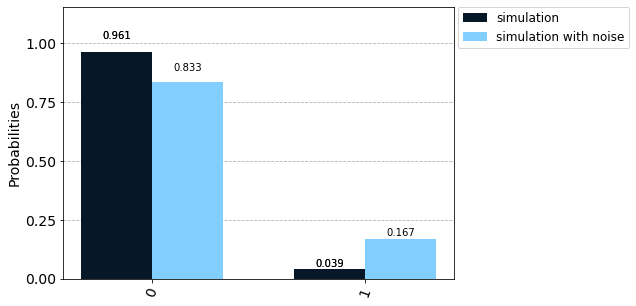

In [47]:
plot_histogram([c,cn], legend= ['simulation','simulation with noise'], color=['#061727','#82cfff'])

 ## 3. Correr num computador quántico

In [48]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [49]:
shots = 1024
job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bcf5f15f4eaa102edafb5e


In [51]:
job_get=backend_device.retrieve_job("60bcf5f15f4eaa102edafb5e")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

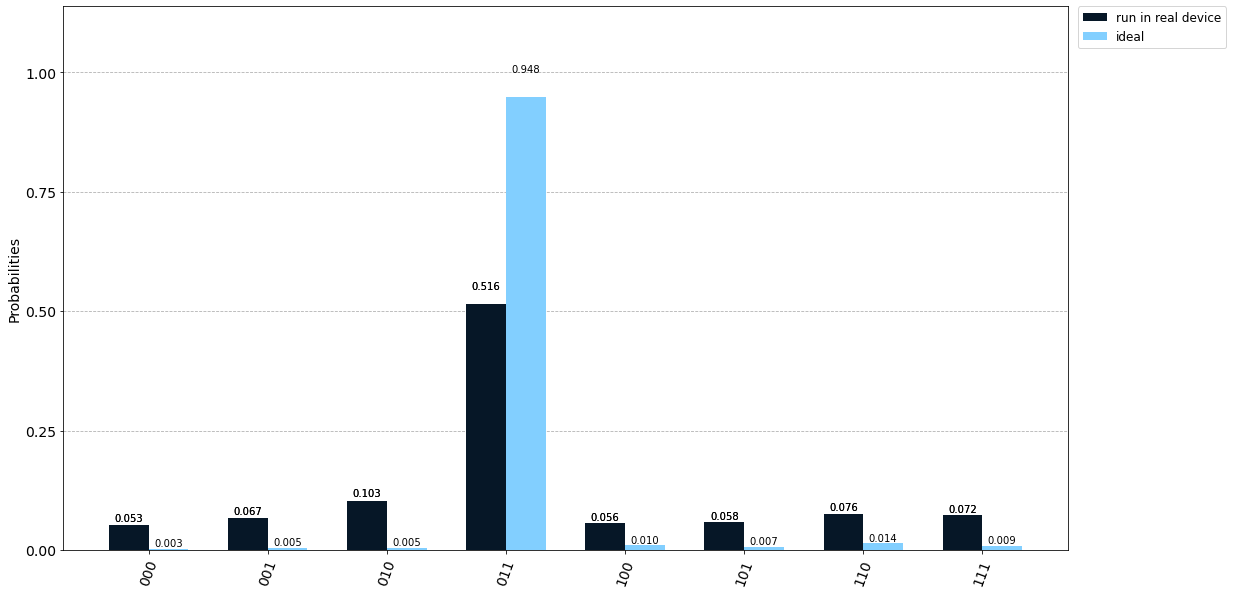

In [52]:
plot_histogram([counts_run, counts ], legend=[ 'run in real device', 'ideal'], color=['#061727','#82cfff'], figsize=(18, 10))

## 4. Mitigação de erros com IGNIS

In [53]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [54]:
qr_ignis = QuantumRegister(x)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_ignis, circlabel='mcal')

In [55]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [56]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)
jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bcf64525cc6e001265d4f0


In [57]:
job_get=backend_device.retrieve_job("60bcf64525cc6e001265d4f0")

cal_results = job_get.result()

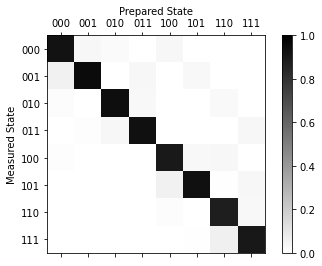

In [58]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_fitter.plot_calibration()

In [59]:
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.920532


#### Applying Calibration

In [60]:
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

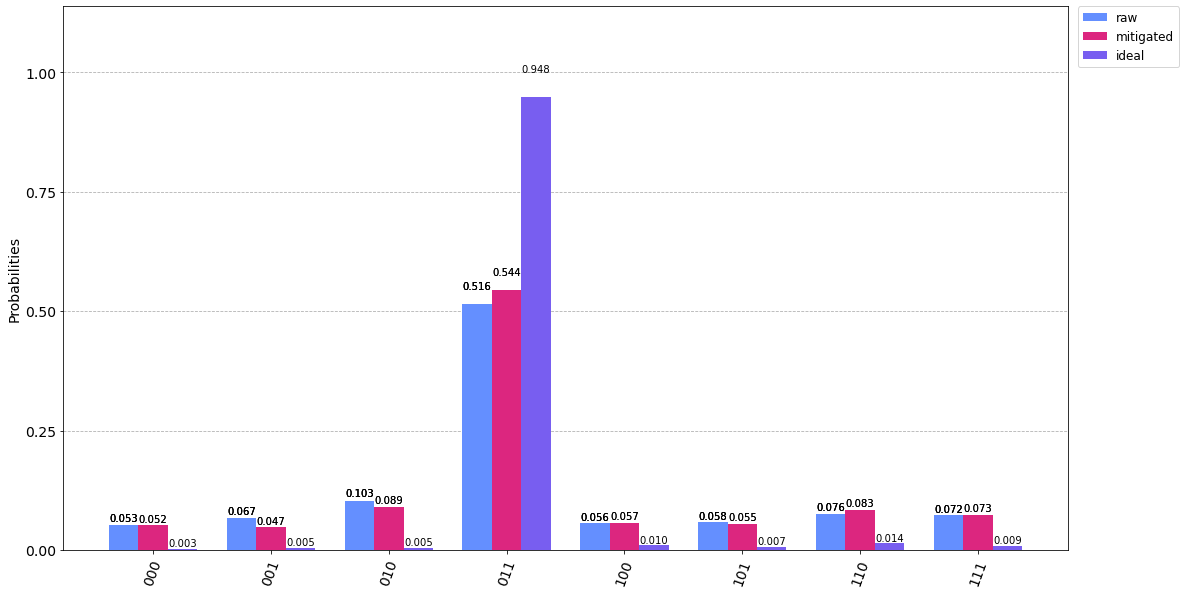

In [61]:
plot_histogram([counts_run, mitigated_counts, counts], legend=['raw', 'mitigated', 'ideal'], figsize=(18, 10))